In [6]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np

import datetime as dt
from scipy.stats import skew, kurtosis
from sklearn import preprocessing, model_selection, metrics

import lightgbm as lgb

import matplotlib.pyplot as plt
%matplotlib inline

from pathlib import Path
import os
pd.options.display.max_columns = 1000

In [7]:
DATA_PATH = Path("data/")

In [8]:
train = pd.read_csv(DATA_PATH/"train.csv", parse_dates=["impression_time"])
test = pd.read_csv(DATA_PATH/"test.csv", parse_dates=["impression_time"])

view_log = pd.read_csv(DATA_PATH/"view_log.csv", parse_dates=["server_time"])
item_data = pd.read_csv(DATA_PATH/"item_data.csv")

view_log_item_data = view_log.merge(item_data, on="item_id", how="left")

In [9]:
view_log_item_data["hour"] = view_log_item_data["server_time"].dt.hour

In [10]:
app_code_agg1 = train.groupby("app_code").agg({"is_click": "mean"})

In [11]:
app_code_agg1.columns = ['mn_isclick_appcode']
app_code_agg1 = app_code_agg1.reset_index(drop = False)

In [12]:
app_code_agg1.head(10)

,app_code,mn_isclick_appcode
0,0,0.082192
1,1,0.085714
2,2,0.067164
3,3,0.034424
4,4,0.000000
5,5,0.073306
6,6,0.000000
7,7,0.058366
8,8,0.156250
9,9,0.063800


In [13]:
tmp = view_log_item_data.groupby("user_id").agg({"server_time": [("user_count", "count")],
#                                                                "device_type": [("num_device_types", lambda x: np.unique(x).size)],
                                                 "session_id": [("num_sessions", lambda x: np.unique(x).size)],
                                                 "item_id": [("num_items", lambda x: np.unique(x).size)],
                                                 "item_price": [("mean_item_price", "mean"),
                                                                ("min_item_price", "min"),
                                                                ("max_item_price", "max"),
                                                                ("sd_item_price", lambda x: np.std(x))
#                                                                                 ("skew_item_price", lambda x: skew(x)),
#                                                                                 ("kurtosis_item_price", lambda x: kurtosis(x))
                                                               ],
                                                 "category_1": [("num_category_1", lambda x: np.unique(x).size)],
                                                 "category_2": [("num_category_2", lambda x: np.unique(x).size)],
                                                 "category_3": [("num_category_3", lambda x: np.unique(x).size)],
                                                 "product_type": [("num_product_type", lambda x: np.unique(x).size)],
                                                })
tmp.columns = tmp.columns.droplevel()
tmp = tmp.reset_index(drop=False)

In [14]:
tmpx = view_log_item_data[view_log_item_data['server_time'] >= '2018-11-15'].groupby("user_id").agg({"server_time": [("user_count_rct", "count")],
#                                                                "device_type": [("num_device_types", lambda x: np.unique(x).size)],
                                                 "session_id": [("num_sessions_rct", lambda x: np.unique(x).size)],
                                                 "item_id": [("num_items_rct", lambda x: np.unique(x).size)],
                                                 "item_price": [("mean_item_price_rct", "mean"),
                                                                ("min_item_price_rct", "min"),
                                                                ("max_item_price_rct", "max"),
                                                                ("sd_item_price_rct", lambda x: np.std(x))
#                                                                                 ("skew_item_price", lambda x: skew(x)),
#                                                                                 ("kurtosis_item_price", lambda x: kurtosis(x))
                                                               ],
                                                 "category_1": [("num_category_1_rct", lambda x: np.unique(x).size)],
                                                 "category_2": [("num_category_2_rct", lambda x: np.unique(x).size)],
                                                 "category_3": [("num_category_3_rct", lambda x: np.unique(x).size)],
                                                 "product_type": [("num_product_type_rct", lambda x: np.unique(x).size)],
                                                })
tmpx.columns = tmpx.columns.droplevel()
tmpx = tmpx.reset_index(drop=False)

In [15]:
tmp1 = view_log_item_data.pivot_table(index="user_id", 
                                      columns="category_1", 
                                      values="server_time", aggfunc="count").fillna(0)
tmp1.columns.name = None
tmp1.columns = [f"category_1_{int(category_type)}" for category_type in tmp1.columns]
tmp1 = tmp1.reset_index()

In [16]:
tmpx1 = view_log_item_data[view_log_item_data['server_time'] >= '2018-11-15'].pivot_table(index="user_id", 
                                      columns="category_1", 
                                      values="server_time", aggfunc="count").fillna(0)
tmpx1.columns.name = None
tmpx1.columns = [f"category_1_rct_{int(category_type)}" for category_type in tmpx1.columns]
tmpx1 = tmpx1.reset_index()

In [17]:
tmp2 = view_log_item_data.pivot_table(index="user_id", 
                                      columns="category_2", 
                                      values="server_time", aggfunc="count").fillna(0)
tmp2.columns.name = None
tmp2.columns = [f"category_2_{int(category_type)}" for category_type in tmp2.columns]
tmp2 = tmp2.reset_index()

In [18]:
tmpx2 = view_log_item_data[view_log_item_data['server_time'] >= '2018-11-15'].pivot_table(index="user_id", 
                                      columns="category_2", 
                                      values="server_time", aggfunc="count").fillna(0)
tmpx2.columns.name = None
tmpx2.columns = [f"category_2_rct_{int(category_type)}" for category_type in tmpx2.columns]
tmpx2 = tmpx2.reset_index()

In [36]:
train["is_train"] = 1
test["is_train"] = 0

panel = pd.concat([train, test], sort=False, ignore_index=True)

In [37]:
panel = (panel.merge(tmp, on="user_id", how="left")
              .merge(tmp1, on="user_id", how="left")
              .merge(tmp2, on="user_id", how="left")
        .merge(tmpx, on="user_id", how="left")
        .merge(tmpx1, on="user_id", how="left")
        .merge(tmpx2, on="user_id", how="left")
        .merge(app_code_agg1,on='app_code',how ='left'))

In [38]:
os_version_mapper = {"latest": 2, "intermediate": 1, "old": 0}
panel["os_version"] = panel["os_version"].map(os_version_mapper)

In [39]:
# panel["day"] = panel["impression_time"].dt.day
panel["dayofweek"] = panel["impression_time"].dt.dayofweek
panel["hour"] = panel["impression_time"].dt.hour

In [40]:
for col in ["user_id", "app_code", 
            ["user_id", "app_code"], ["app_code", "os_version"]]:
    if not isinstance(col, list):
        col = [col]
    col_name = "_".join(col)
    all_df = panel[["impression_id"] + col].copy()
    gdf = all_df.groupby(col)["impression_id"].count().reset_index()
    gdf.columns = col + [col_name+"_count"]
    panel = pd.merge(panel, gdf, on=col, how="left")

In [41]:
panel.head(10)

,impression_id,impression_time,user_id,app_code,os_version,is_4G,is_click,is_train,user_count,num_sessions,num_items,mean_item_price,min_item_price,max_item_price,sd_item_price,num_category_1,num_category_2,num_category_3,num_product_type,category_1_0,category_1_1,category_1_2,category_1_4,category_1_5,category_1_6,category_1_7,category_1_8,category_1_9,category_1_10,category_1_11,category_1_12,category_1_13,category_1_14,category_1_15,category_1_16,category_1_17,category_2_0,category_2_1,category_2_2,category_2_3,category_2_4,category_2_5,category_2_6,category_2_7,category_2_8,category_2_9,category_2_10,category_2_11,category_2_12,category_2_13,category_2_14,category_2_15,category_2_16,category_2_17,category_2_18,category_2_19,category_2_20,category_2_21,category_2_22,category_2_23,category_2_24,category_2_25,category_2_26,category_2_27,category_2_28,category_2_29,category_2_30,category_2_31,category_2_33,category_2_34,category_2_35,category_2_36,category_2_37,category_2_38,category_2_39,category_2_40,category_2_41,category_2_42,category_2_43,category_2_44,category_2_45,category_2_46,category_2_47,category_2_48,category_2_49,category_2_50,category_2_51,category_2_52,category_2_53,category_2_54,category_2_55,category_2_56,category_2_57,category_2_58,category_2_59,category_2_60,category_2_61,category_2_62,category_2_63,category_2_64,category_2_65,category_2_66,category_2_67,category_2_68,category_2_69,category_2_70,category_2_71,category_2_72,category_2_73,category_2_74,category_2_75,category_2_76,category_2_77,category_2_78,category_2_79,user_count_rct,num_sessions_rct,num_items_rct,mean_item_price_rct,min_item_price_rct,max_item_price_rct,sd_item_price_rct,num_category_1_rct,num_category_2_rct,num_category_3_rct,num_product_type_rct,category_1_rct_0,category_1_rct_1,category_1_rct_2,category_1_rct_4,category_1_rct_6,category_1_rct_7,category_1_rct_8,category_1_rct_9,category_1_rct_10,category_1_rct_11,category_1_rct_12,category_1_rct_13,category_1_rct_14,category_1_rct_15,category_1_rct_16,category_1_rct_17,category_2_rct_0,category_2_rct_1,category_2_rct_2,category_2_rct_3,category_2_rct_4,category_2_rct_5,category_2_rct_6,category_2_rct_7,category_2_rct_8,category_2_rct_9,category_2_rct_10,category_2_rct_11,category_2_rct_12,category_2_rct_13,category_2_rct_14,category_2_rct_15,category_2_rct_16,category_2_rct_17,category_2_rct_18,category_2_rct_19,category_2_rct_20,category_2_rct_21,category_2_rct_22,category_2_rct_23,category_2_rct_24,category_2_rct_25,category_2_rct_26,category_2_rct_27,category_2_rct_28,category_2_rct_29,category_2_rct_30,category_2_rct_31,category_2_rct_33,category_2_rct_34,category_2_rct_35,category_2_rct_36,category_2_rct_37,category_2_rct_38,category_2_rct_39,category_2_rct_40,category_2_rct_41,category_2_rct_42,category_2_rct_43,category_2_rct_44,category_2_rct_45,category_2_rct_46,category_2_rct_47,category_2_rct_48,category_2_rct_49,category_2_rct_50,category_2_rct_51,category_2_rct_52,category_2_rct_53,category_2_rct_54,category_2_rct_55,category_2_rct_56,category_2_rct_57,category_2_rct_58,category_2_rct_59,category_2_rct_60,category_2_rct_61,category_2_rct_62,category_2_rct_63,category_2_rct_64,category_2_rct_65,category_2_rct_66,category_2_rct_67,category_2_rct_68,category_2_rct_69,category_2_rct_70,category_2_rct_71,category_2_rct_72,category_2_rct_73,category_2_rct_74,category_2_rct_76,category_2_rct_77,category_2_rct_78,category_2_rct_79,mn_isclick_appcode,dayofweek,hour,user_id_count,app_code_count,user_id_app_code_count,app_code_os_version_count
0,c4ca4238a0b923820dcc509a6f75849b,2018-11-15 00:00:00,87862,422,0,0,0.0,1,1,1,1,2350.000000,2350.0,2350.0,0.000000,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

In [42]:
tpx = panel.groupby(["app_code"]).agg({"user_id":(lambda x: np.unique(x).size),
                                      "num_sessions":"sum",
                                       "num_items":"sum",
                                       "mean_item_price":"mean",
                                       "min_item_price":"min",
                                       "max_item_price":"max"})
#tpx.columns = tpx.columns.droplevel()
tpx.columns = ["ac_user_count","ac_num_sessions","ac_num_items","ac_mean_item_price","ac_min_item_price","ac_max_item_price"]
tpx = tpx.reset_index(drop= False)
tpx.head(5)

,app_code,ac_user_count,ac_num_sessions,ac_num_items,ac_mean_item_price,ac_min_item_price,ac_max_item_price
0,0,39,1527,2861,11418.962507,64.0,343040.0
1,1,28,871,1173,12308.724361,80.0,209024.0
2,2,67,2295,5912,9748.932723,17.0,258240.0
3,3,2479,143168,243262,11221.969851,6.0,648960.0
4,4,2,19,31,12050.324786,313.0,48320.0


In [44]:
panel = (panel.merge(tpx, on="app_code", how="left"))

In [45]:
columns_for_model = np.setdiff1d(panel.columns.values, ["impression_id",
                                                        "impression_time",
                                                        "is_click",
                                                        "is_train",'mn_isclick_appcode']).tolist()
train_X = panel.loc[panel["is_train"] == 1, columns_for_model + ["is_click"]].reset_index(drop=True)
test_X = panel.loc[panel["is_train"] == 0, ["impression_id"]+columns_for_model].reset_index(drop=True)

train_y = train_X["is_click"].values

train_X = train_X.drop(["is_click"], axis=1)
test_ids = test_X["impression_id"].values
test_X = test_X.drop(["impression_id"], axis=1)
print(train_X.shape, test_X.shape)

(237609, 235) (90675, 235)


In [46]:
columns_for_model

['ac_max_item_price_x',
 'ac_max_item_price_y',
 'ac_mean_item_price_x',
 'ac_mean_item_price_y',
 'ac_min_item_price_x',
 'ac_min_item_price_y',
 'ac_num_items_x',
 'ac_num_items_y',
 'ac_num_sessions_x',
 'ac_num_sessions_y',
 'ac_user_count_x',
 'ac_user_count_y',
 'app_code',
 'app_code_count',
 'app_code_os_version_count',
 'category_1_0',
 'category_1_1',
 'category_1_10',
 'category_1_11',
 'category_1_12',
 'category_1_13',
 'category_1_14',
 'category_1_15',
 'category_1_16',
 'category_1_17',
 'category_1_2',
 'category_1_4',
 'category_1_5',
 'category_1_6',
 'category_1_7',
 'category_1_8',
 'category_1_9',
 'category_1_rct_0',
 'category_1_rct_1',
 'category_1_rct_10',
 'category_1_rct_11',
 'category_1_rct_12',
 'category_1_rct_13',
 'category_1_rct_14',
 'category_1_rct_15',
 'category_1_rct_16',
 'category_1_rct_17',
 'category_1_rct_2',
 'category_1_rct_4',
 'category_1_rct_6',
 'category_1_rct_7',
 'category_1_rct_8',
 'category_1_rct_9',
 'category_2_0',
 'category_2

In [47]:
def runLGB(train_X, train_y, test_X, test_y=None, test_X2=None, dep=8, seed=0, data_leaf=511, hessian_leaf=50):  
    params = {}
    params["objective"] = "binary"
    params['metric'] = 'auc'
#     params["max_depth"] = dep
    params["num_leaves"] = 63
    params["min_data_in_leaf"] = data_leaf
    params["min_sum_hessian_in_leaf"] = hessian_leaf
    params["learning_rate"] = 0.01
    params["bagging_fraction"] = 0.913
    params["feature_fraction"] = 0.2
    params["feature_fraction_seed"] = seed
    params["bagging_freq"] = 8
    params["bagging_seed"] = seed
    params["lambda_l2"] = 0.95
    params["lambda_l1"] = 0.95
    params["verbosity"] = -1
    num_rounds = 20000

    plst = list(params.items())
    lgtrain = lgb.Dataset(train_X, label=train_y)

    if test_y is not None:
        lgtest = lgb.Dataset(test_X, label=test_y)
        model = lgb.train(params, lgtrain, num_rounds, valid_sets=[lgtest], early_stopping_rounds=200, verbose_eval=500)
    else:
        lgtest = lgb.DMatrix(test_X)
        model = lgb.train(params, lgtrain, num_rounds)

    pred_test_y = model.predict(test_X, num_iteration=model.best_iteration)
    pred_test_y2 = model.predict(test_X2, num_iteration=model.best_iteration)

    loss = 0
    if test_y is not None:
        loss = metrics.roc_auc_score(test_y, pred_test_y)
        print(loss)
        return model, loss, pred_test_y, pred_test_y2
    else:
        return model, loss, pred_test_y, pred_test_y2

In [48]:
print("Building model..")
cv_scores = []
pred_test_full = 0
pred_train = np.zeros(train_X.shape[0])
n_splits = 5
kf = model_selection.KFold(n_splits=n_splits, shuffle=True, random_state=7988)
model_name = "lgb"
for dev_index, val_index in kf.split(train_X, train_y):
    dev_X, val_X = train_X.iloc[dev_index,:], train_X.iloc[val_index,:]
    dev_y, val_y = train_y[dev_index], train_y[val_index]

    pred_val = 0
    pred_test = 0
    n_models = 0.

    model, loss, pred_v, pred_t = runLGB(dev_X, dev_y, val_X, val_y, test_X, seed=2019)
    pred_val += pred_v
    pred_test += pred_t
    n_models += 1
    
#     model, loss, pred_v, pred_t = runLGB(dev_X, dev_y, val_X, val_y, test_X, data_leaf=450, hessian_leaf=30, seed=9873)
#     pred_val += pred_v
#     pred_test += pred_t
#     n_models += 1
    
#     model, loss, pred_v, pred_t = runLGB(dev_X, dev_y, val_X, val_y, test_X, data_leaf=600, hessian_leaf=70, seed=4568)
#     pred_val += pred_v
#     pred_test += pred_t
#     n_models += 1
    
    pred_val /= n_models
    pred_test /= n_models
    
    loss = metrics.roc_auc_score(val_y, pred_val)
        
    pred_train[val_index] = pred_val
    pred_test_full += pred_test / n_splits
    cv_scores.append(loss)
    break
print(np.mean(cv_scores))

Building model..
Training until validation scores don't improve for 200 rounds.
[500]	valid_0's auc: 0.740588
[1000]	valid_0's auc: 0.745916
[1500]	valid_0's auc: 0.747096
Early stopping, best iteration is:
[1766]	valid_0's auc: 0.74733
0.7473304513967005
0.7473304513967005


In [31]:
submit = pd.DataFrame({"impression_id": test_ids, "is_click": pred_test_full})

In [32]:
max(submit['is_click'])

0.6473523094649438

In [33]:
submit.to_csv("submit_baseline_kfold_0_7549_v2.csv", index=False)

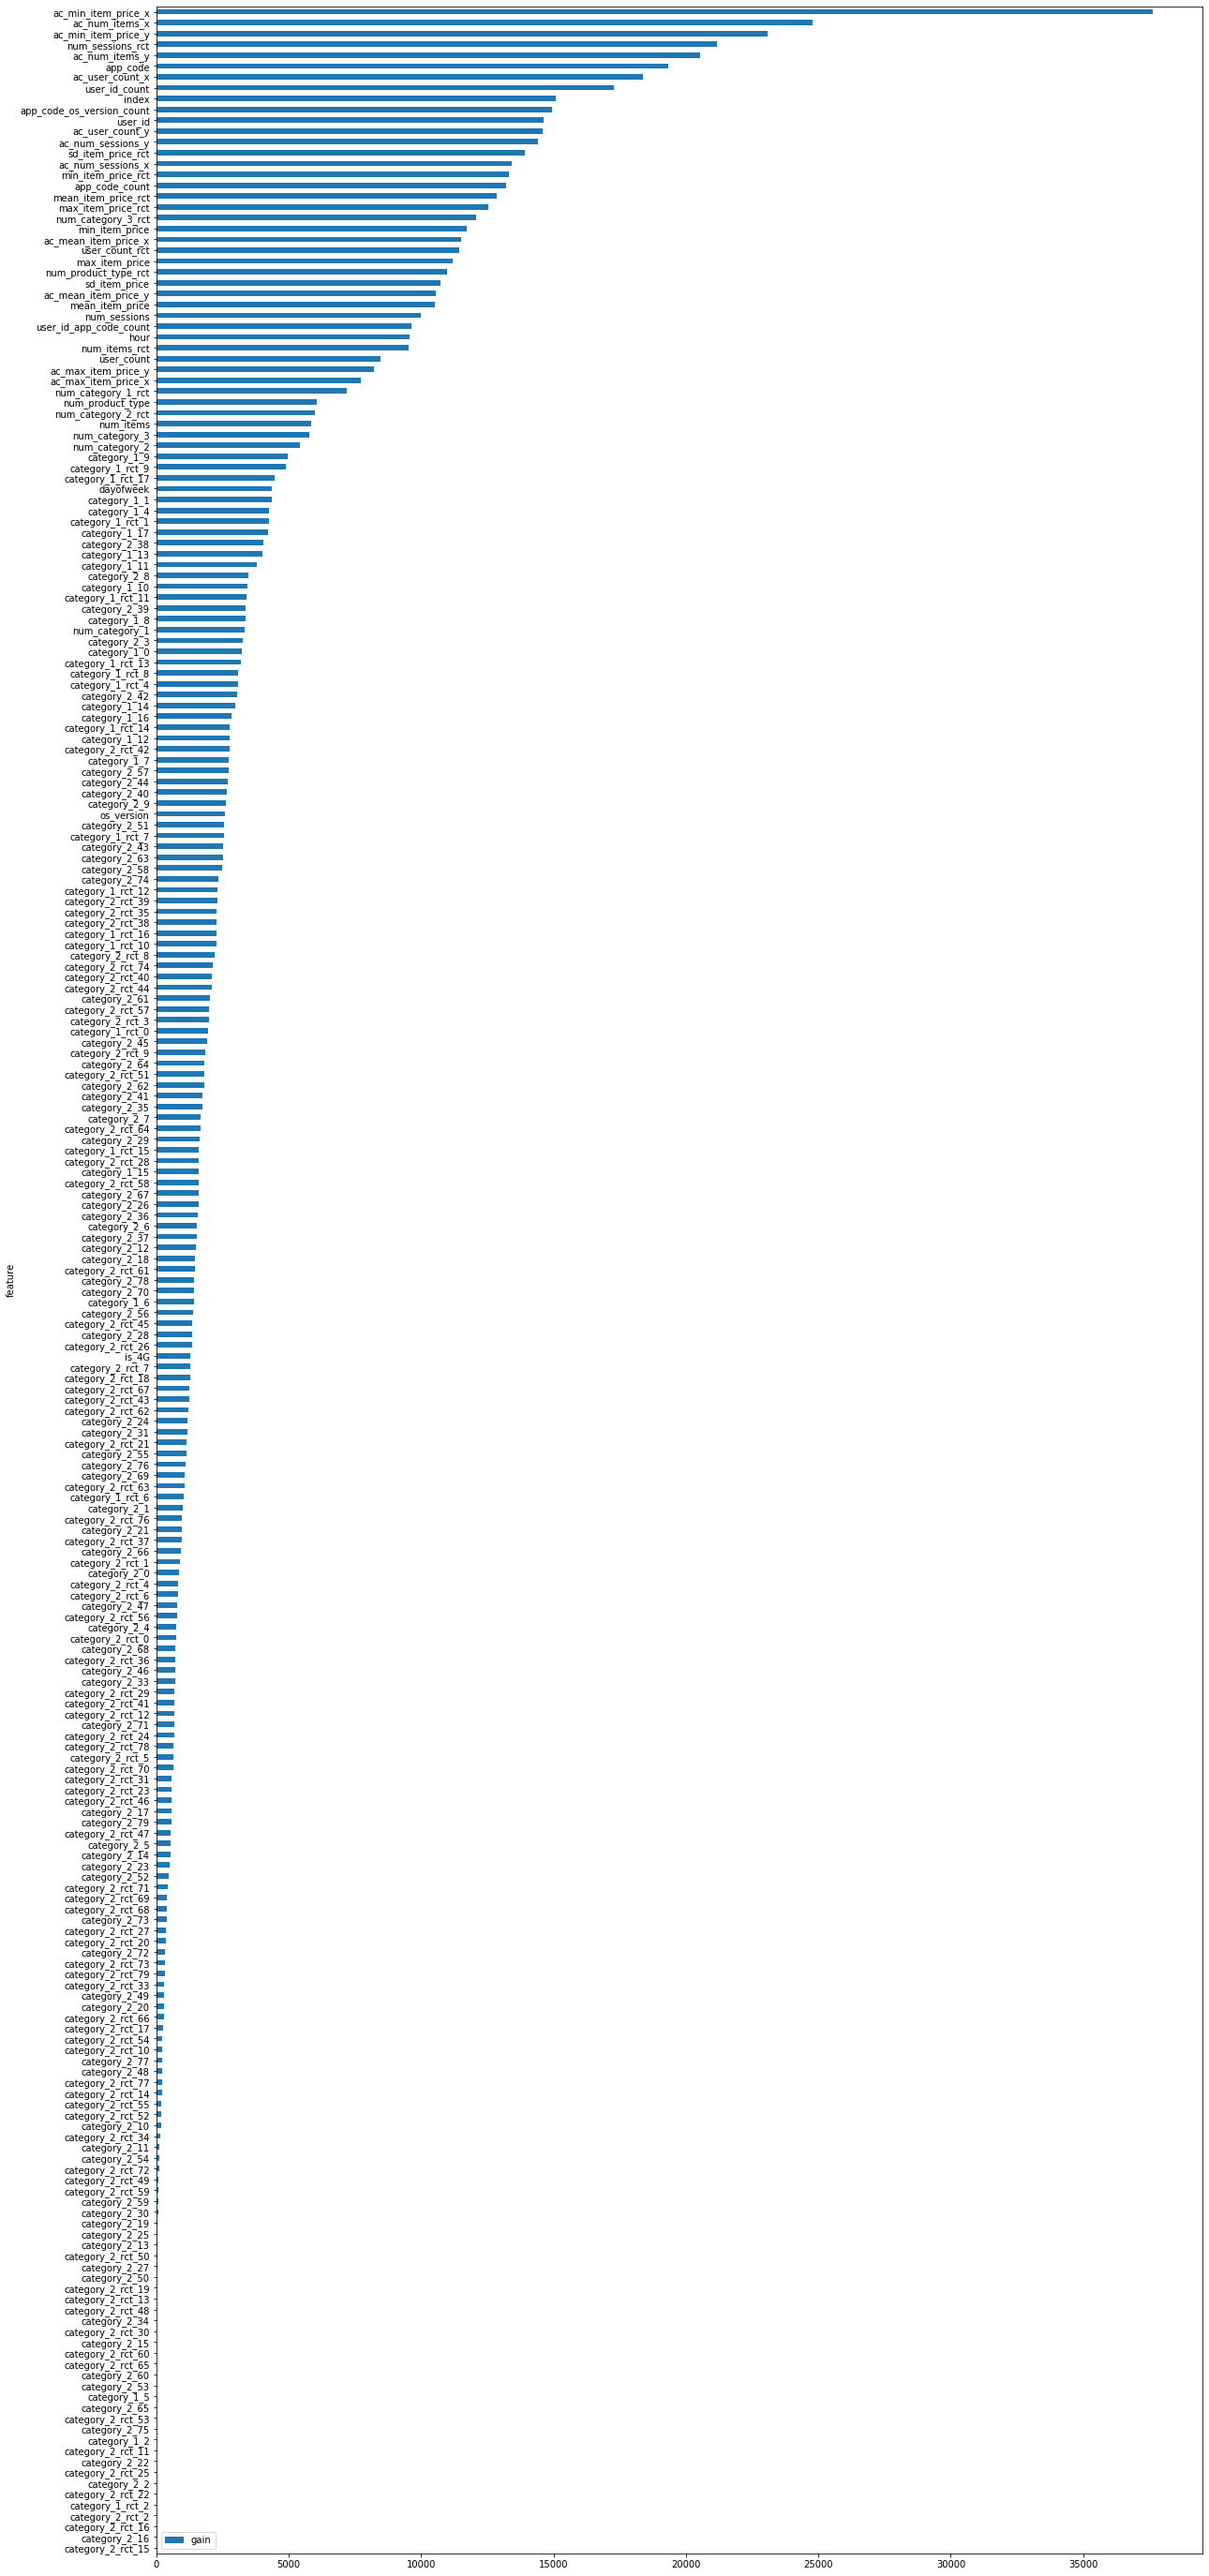

In [49]:
(pd.DataFrame({"feature": model.feature_name(), 
              "gain": model.feature_importance(importance_type="gain")})
     .sort_values("gain", ascending=True).set_index("feature").plot(kind="barh", figsize=(20,50)))